# Truncated mass distribution collapse simulation


In this notwbook we're going to simulate the collapse of a truncated sphere mass distribution. We're going to infer how the masses collapse in the $T_{dyn}$ (dynamical time) and if they somehow expand in the outer space without crushing on one another. 

## Basics on this type of system

We decided to study the case of a $\textit{Keplerian potential}$ in an homogeneous sphere that's truncated at a given radius $a$. 


![](trunc_sphere.png)


The $\rho_0$ density parameter is defined as constant inside the sphere, qhile it's null elsewhere. The following relationships stand: 

$$M(R)=\frac{4 \pi}{3} \rho_0 R^{3}$$

$$v(R)=\sqrt{\frac{4 \pi G}{3} \rho_0} R$$

$$T_{orbital}=\frac{2 \pi R}{v(R)} =  \sqrt{\frac{3 \pi}{G \rho_{0}}}$$


We can define the $\textbf{dynamical time}$ as the time to go from $R$ to 0, starting with $v = 0$ with respect to the distribution, and $\textit{assuming}$ a static potential $\Phi$.

Skipping the passages to get here (we all know them :) ) this is what we get: 

$$T_{dynam} = \sqrt{\frac{3 \pi}{16 G \rho_0}}$$

The system stability is tested over multple dynamical times, for instance $20 \cdot T_{dynam}$. Usually, if the system is not stable we have another quantity that's useful to know: the $\textbf{collapse time}$. Again, skipping all the passages to get here: 

$$t_{coll} = \sqrt{\frac{3 \pi}{32 G \rho_0}} = \frac{T_{dynam}}{\sqrt{2}}$$

What are the implications of a spherical distribution such as the one described above in real life? Such a system, if real would collapse to the center due to its own gravity and produce a supermassive black hole. This does not happen due to some discrepancies with the theory: 

- 1) Are we really sure that the system is homogeneous and isotropic?
- 2) At some point the Newtonian dynamics won't work anymore; 
- 3) We only have finite $Ns$ of particles, not $\inf$, this is totally related to the above points. The particles can change their energy drastically due to transfer from system and other particles. The total energy is conserved, some particles become more bound and some are ejected even if their energy was initially negative. 

This summarizes well what we're (hopefully!) going to investigate in the following lines. 

## Analysis: 

We followed these steps: 

- We generated the N masses to work with, according to their correct distribution; 
- We produced the input file for the simulation; 
- We simulated the N-body problem; 
- We analyzed the outcoming results, checking their consistency. 

In [6]:
import numpy as np
import matplotlib

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [8]:
# set initial variables/ uninitialized arrays

N = 100
M = 1 # * N
m = M / N
a = 1

In [4]:
from scipy.stats import uniform

Generating the masses of the truncated sphere: 

In [5]:
cdf_r = uniform.rvs(0, 1, size=N)  # cumulative function of rs
rays = a * (cdf_r / 3)**(1/3)

cdf_theta = uniform.rvs(0, 1, size=N)  # cumulative function of thetas
thetas = np.arccos(1 - 2 * cdf_theta)

phis = uniform.rvs(0, 2 * np.pi, size=N)

Converting to $\textbf{cartesian}$ coordinates: 

In [6]:
x = rays * np.sin(thetas) * np.cos(phis)
y = rays * np.sin(thetas) * np.sin(phis)
z = rays * np.cos(thetas) 

Check the generated distribution with the 3D plot: 

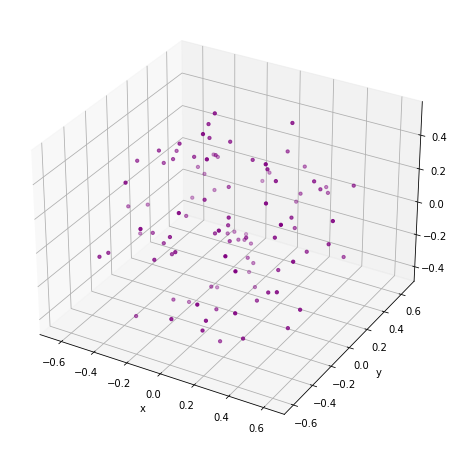

In [7]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, c = 'purple', s=10.5)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show();

Here we decided to check that equal volumes inside our distribution correspond to an equal number of masses (definition of uniform distribution): 

In [8]:
V_sphere = 4 * np.pi / 3 * a**3
test_frac = 100
V_test = V_sphere / test_frac

def VolumeTest(V_test, r, theta, phi): 
    
    # Uniform generation of the coordinates, otherwise it is a tautology
    
    rs_test = uniform.rvs(0, a, size=2)
    thetas_test = uniform.rvs(0, np.pi, size=2)
    phi1_test = uniform.rvs(0, 2 * np.pi)
    
    # Sorting to get the correct form of the result
    
    r1_test = rs_test.min()
    r2_test = rs_test.max()
    
    theta1_test = thetas_test.min()
    theta2_test = thetas_test.max()
    
    f_theta = 0.5*(- theta1_test + np.sin(theta1_test) * np.cos(theta1_test) + theta2_test - np.sin(theta2_test)*np.cos(theta2_test))
    
    phi2_test = phi1_test + 3 * V_test / (f_theta * (r2_test - r1_test)**3)
    
    # Check the points lying within the volume
    
    enclosed_points = ((r >= r1_test) & (r <= r2_test) & (theta >= theta1_test) & (theta <= theta2_test) & (phi >= phi1_test) & (phi <= phi2_test))
    
    # Count the number of enclosed points
    num_enclosed_points = np.sum(enclosed_points)
    
    return num_enclosed_points

In [9]:
Ntest = 10000

bodies_number_array = np.array([VolumeTest(V_test, rays, thetas, phis) for i in range(Ntest)])

expected_bodies = N / V_sphere * V_test

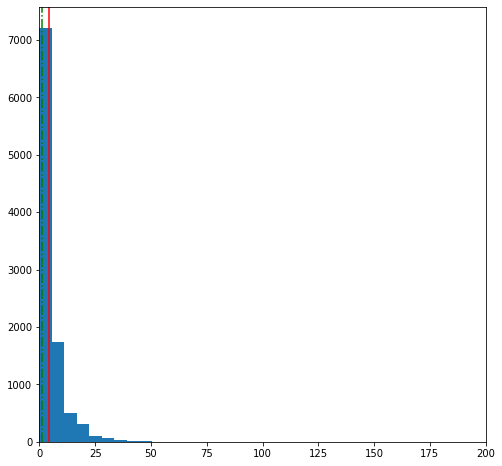

In [10]:
plt.figure(figsize = (8,8))

plt.hist(bodies_number_array, 10)
plt.axvline(expected_bodies, ls='-.', c='green')
plt.axvline(np.mean(bodies_number_array), ls='-', c='r')
plt.xlim(0, 200)
plt.show()

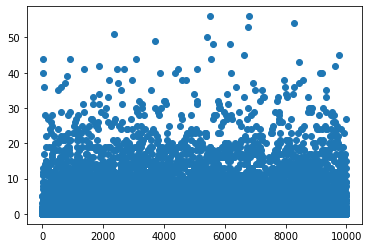

In [11]:
plt.scatter(np.arange(0, len(bodies_number_array)), bodies_number_array)

In [12]:
np.mean(bodies_number_array)

4.4486

In [13]:
len(bodies_number_array[bodies_number_array == 0])  # su 10000 7975 sono senza nessuna massa

2993

### Initial conditions file:

In [14]:
# open the file
file = open('homogeneous_sphere_initial.txt', 'w')

# write the file
file.write(f'{N}\n')
file.write('0\n')
for i in range(N):
    file.write(f'{m} {x[i]} {y[i]} {z[i]} {0} {0} {0}\n')

# close the file
file.close()

We set some easy functions to extract the dynamical and collapse time. 

In [15]:
def dyn_time(rho_0): 
    
    G = 1
    
    return np.sqrt(3 * np.pi / (16 * G * rho_0)) 

def coll_time(rho_0): 
    
    G = 1
    
    return np.sqrt(3 * np.pi / (32 * G * rho_0))

To plug something in we need to evaluate $\rho_0$: 

In [16]:
rho0 = M / V_sphere # N * 1 masses of stars

In [17]:
rho0

0.23873241463784303

Printing then both of them (it totally makes sense to do so, in order to establish the duration of the simulation):

In [18]:
print("The dynamical time is: ", dyn_time(rho0))
print("The collapse time is: ", coll_time(rho0))

The dynamical time is:  1.5707963267948963
The collapse time is:  1.1107207345395915


## Simulation results: 

As for the previous $\textit{hands-on}$ session, we produced some plots and animations to better understand the result. 

Here there are just some code pieces to get the data from the output files. 

In [9]:
import pandas as pd

In [10]:
fname = 'collapse_results.out'

In [11]:
data = pd.read_csv(fname).to_numpy()

In [12]:
times = data[0::(N+2)].astype(float)

m = {}

for i in range(1, N + 1):
    
    m[f"{i}"]= data[i::(N+2)]  # take only the components every N+1 rows

In [13]:
# split the array (we don't like numbers strings to work with): 

m_data = {}

for j in range(1, N + 1):

    m_data[f"{j}"] = np.array([m[f"{j}"][i][0].split() for i in range(0, len(m[f"{j}"]))]).astype(float)

Just as a reminder of how to easily access the data: 

m1 = {
    
    "m1" : m1_data_1[:, 0],
    "x1" : m1_data_1[:, 1],
    "x2" : m1_data_1[:, 2],
    "x3" : m1_data_1[:, 3],
    "v1" : m1_data_1[:, 4],
    "v2" : m1_data_1[:, 5],
    "v3" : m1_data_1[:, 6]
    
}

In [14]:
times_plot = np.hstack(times)

Finally getting to the actual 3D plot:

(-0.5, 0.5)

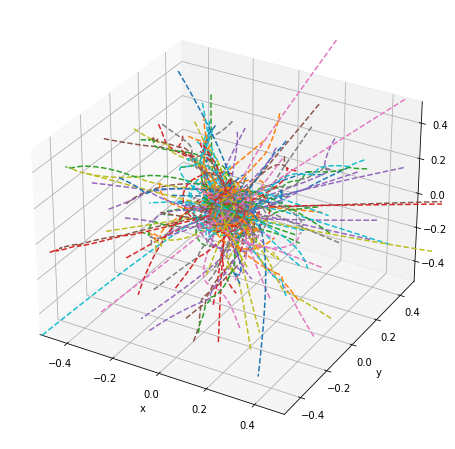

In [15]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,8))

for i in range(1, N + 1):

    ax.plot(m_data[f"{i}"][:, 1], m_data[f"{i}"][:, 2], m_data[f"{i}"][:, 3], label=f"{i}th particle", linestyle='--')

    
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(-0.5, 0.5)

#plt.legend()

Let's see some animation, because this is kind of a mess :). 

In [31]:
import matplotlib.animation as animation

def update(num):
    
    ax.clear() 
    
    for i in range(1, N): 
    
        ax.scatter(m_data[f"{i}"][num, 1], m_data[f"{i}"][num, 2], m_data[f"{i}"][num, 3], s=2.5)             
        
        #ax.scatter(m_data[f"{i}"][num, 1], m_data[f"{i}"][num, 2], m_data[f"{i}"][num, 3], marker='o', size=3.5, c='red')   
    
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        ax.set_zlabel(r'$z$')
        
        ax.set_xlim(-0.5, 0.5)
        ax.set_ylim(-0.5, 0.5)
        ax.set_zlim(-0.5, 0.5)

<IPython.core.display.Javascript object>


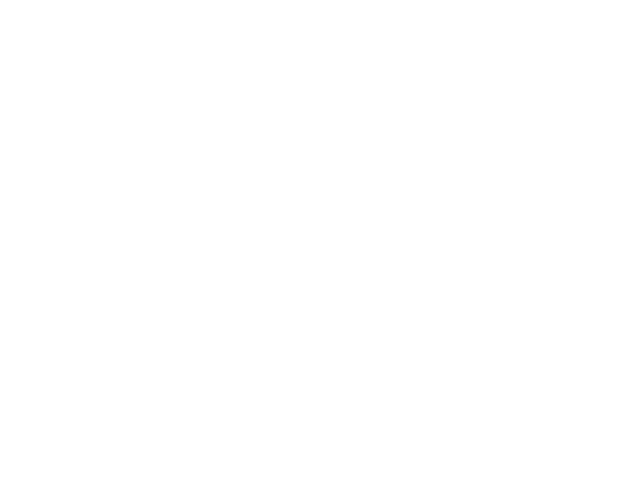

/var/folders/x1/_4_0wf6n3vbb18gn1psjd98w0000gn/T/ipykernel_69929/2770235407.py:16: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


In [33]:
%matplotlib notebook 


## Plotting the Animation
fig = plt.figure()
ax = plt.axes(projection='3d')
numDataPoints = len(m_data["100"][:, 3])
line_ani = animation.FuncAnimation(fig, update, interval=10, frames=numDataPoints, blit=True)

# Saving the Animation
f = r"N_100.gif"
writergif = animation.PillowWriter(fps=10)
line_ani.save(f, writer=writergif);


plt.close()

![](N_100.gif)

## Comments and observations

The simulation result provides a deep insight on the theory we explained at the beginning. We see that as times passes come of the masses are scattered around and others remain bound. This behaviour was expected because of the random generated points that were not placed at the exact opposites of the sphere, making it difficult to obtain a collapse in the same $R=0$ point. We can eventually check whether it is correct that the trajectories vary the way we see in the 3D plot. 

## Radii analysis

In [16]:
r_t = {}  # set an array where to store rays at different ts

for i in range(1, N + 1):  
    
    r_t[f"{i}"] = np.sqrt(m_data[f"{i}"][:, 1]**2 + m_data[f"{i}"][:, 2]**2 + m_data[f"{i}"][:, 3]**2)

Let's see how different masses behave depending on their initial $\textit{relative}$ position:

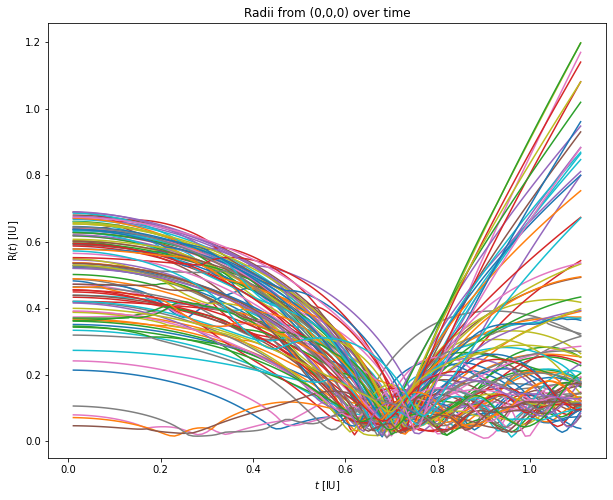

In [27]:
plt.figure(figsize = (10,8))

for i in range(1, N + 1):

    plt.plot(times_plot, r_t[f"{i}"][:], label = f"{i} mass")

plt.xlabel("$t$ [IU]")
plt.ylabel("$\mathrm{R}(t)$ [IU]")
plt.title("Radii from (0,0,0) over time")
plt.show()

Let's just compare the two cases: 

- The mass remains bound
- The mass escapes

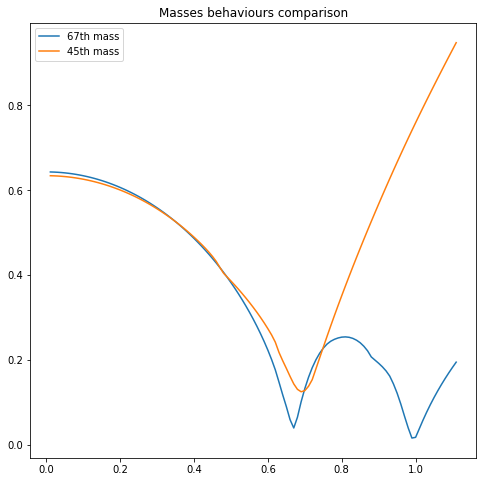

In [38]:
plt.figure(figsize = (8,8))

plt.plot(times_plot, r_t[f"67"][:], label = f"67th mass")
plt.plot(times_plot, r_t[f"45"][:], label = f"45th mass")

plt.title("Masses behaviours comparison")

plt.legend()
plt.show()

Let's see the collapse estimation. I will brutally find the $\textbf{FIRST}$ minimum in the two arrays chating since I know the region where it is. 

In [55]:
import numpy.ma as ma

In [75]:
print("T(r_min) of 67th mass: ", times_plot[np.where(r_t[f"67"] == np.min(r_t[f"67"][ma.masked_inside(times_plot, 0.6, 0.8).mask]))], "s")

T(r_min) of 67th mass:  [0.67002408] s


In [74]:
print("T(r_min) of 45th mass: ", times_plot[np.where(r_t[f"45"] == np.min(r_t[f"45"][ma.masked_inside(times_plot, 0.6, 0.8).mask]))], "s")

T(r_min) of 45th mass:  [0.69001008] s


This is pretty random, I'd really love to see if this works for all masses or if it's just a casuality. Is it a dead end?